# OF example

Load MIDAS data with low pulse rate. Make PSD and pulse templates, then run OF

Changelog

Oct 4 2024: First version

In [1]:
import sys
import glob
sys.path.append('..')
from arqpy import *

In [2]:
# data + channels to use
datadir = '/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/'
filename_pattern = datadir + 'RUN04398_DUMP000*.mid.gz'
fns = sorted(glob.glob(filename_pattern))
chs = ['PCS1','PFS1'] # channels to use (which also serve as dictionary keys)
names = ['TAMU_A','TAMU_B']
#taus = [[1e-5,3e-4],[1e-5,3e-4]] # pulse rise/fall times (seconds)

# general
fsamp = 625000 # Hz
pretrig = 4096 # bins
posttrig = 4096
tracelen = pretrig + posttrig # trace used for RQ processing
psdfreq = np.fft.rfftfreq(tracelen,1/fsamp)
ADC2A = 1/2**16 *8/5e3 /2.4/4 # 16-bit ADC, 8V range, 5kOhm R_FB, 2.4 turn ratio, gain = 4

The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/RUN04398_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/RUN04398_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992408010613
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/RUN04398_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/RUN04398_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992408010613
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/RUN04398_DUMP0000.mid.gz
RawDat

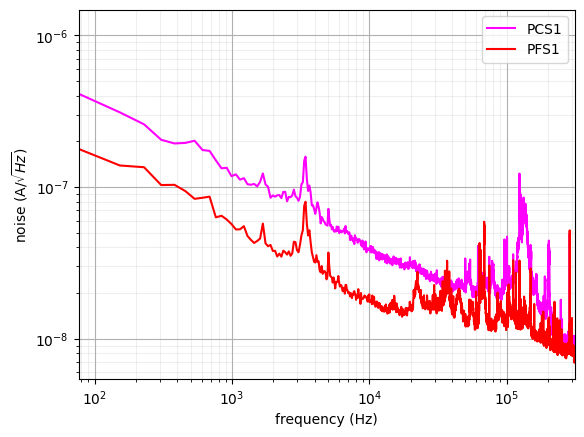

In [3]:
# make PSDs
det = 1 # MIDAS Det01
# load traces - may take a while
traces = loadEvents(files=fns[:1],detectors=[det],chs=chs,ADC2A=ADC2A)
# compute PSDs, then plot
psds = makePSDs(traces[det],chs=chs,nbins=tracelen,ntraces=100,fsamp=fsamp)
plotPSDs(psds,tracelen=tracelen)

32512


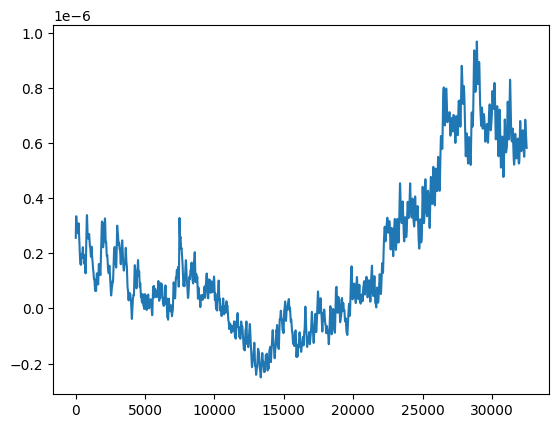

In [4]:
# find a pulse to fit somehow
ch = chs[0]
evn = 34
trace = lpf(traces[1][chs[0]][evn], fcut=1e4, forder=10) # low-pass filter
plt.plot(trace)
print(len(trace))

[5.48475494e-07 8.88328215e-05 1.27749017e-04 9.59989203e-05
 9.51394210e-08]
[ 1.26656674e-07  4.60357259e-05  6.91804685e-05  1.03999977e-04
 -6.48877625e-08]


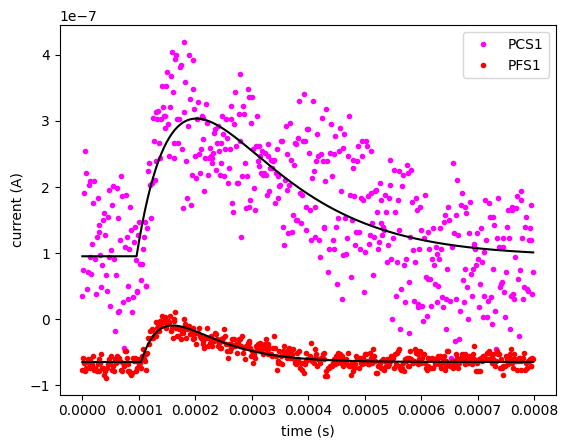

In [5]:
# make pulse templates
templates = {}
evn = 34 # found earlier, for RUN04398_DUMP0001
pulse_ind = 7475
for ch in chs:
    trace = traces[1][ch][evn][pulse_ind-100:pulse_ind+400]
    t = np.arange(len(trace))/fsamp
    mle = fitPulse(t,trace)
    templates[ch] = pulse2(np.arange(tracelen)/fsamp,*mle[1:3])
    print(mle)
    
    # plot
    plt.plot(t,trace,'.',color=MIDAScolors[MIDASchs.index(ch)],label=ch)
    plt.plot(t,mle[0]*pulse2(t,*mle[1:-1])+mle[-1],'k-')
plt.xlabel('time (s)')
plt.ylabel('current (A)')
plt.legend()

In [6]:
# instantiate Reduced Quantity object
rq = RQ(files=fns, chs=chs, ch_names=names, detector=1,
        fsamp=fsamp, ADC2A=ADC2A,
        pretrig=pretrig, posttrig=posttrig, 
        PSDs=psds, pulse_templates=templates,
        max_chi2_freq=1e4)

In [7]:
# make OF (for RQs AND triggering) and plot
rq.makeOF()

In [8]:
# trigger options
trigger_mode = 1 # 0 - threshold, 1 - filter+threshold, 2 - random, 3 - external/LEMO
randomrate = 0 # random triggers to add per trace
trigger_channels = chs # channels to trigger on
trigger_threshold_uA = [0.1, 0.1] # in uA
threshold = {}
deactivation_threshold = {}
for i,ch in enumerate(chs):
    threshold[ch] = trigger_threshold_uA[i]*1e-6 #/ADC2A # OF amp, in ADCu, to trigger on
    deactivation_threshold[ch] = 0.5*threshold[ch]

rq.runTrigger(mode=trigger_mode, chs=trigger_channels, randomrate=randomrate,
              threshold=threshold, deactivation_threshold=deactivation_threshold)
# for fn in fns:
#    load all evs
#    traces = []
#    for ev in evs:
#        trace = filtered(trace)
#        trigs = []
#        for slice:
#              traces.append(slice)

The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/RUN04398_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/RUN04398_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992408010613
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/RUN04398_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/RUN04398_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992408010613
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/RUN04398_DUMP0000.mid.gz
RawDat

In [9]:
''' #debug trigger...
kwargs = {'mode': trigger_mode, 'chs': trigger_channels, 'randomrate': randomrate,
          'threshold': threshold, 'deactivation_threshold': deactivation_threshold}
keys = ['mode','files','chs','trigger_chs','detector','fsamp','ADC2A','pretrig','posttrig',
        'randomrate','filters','window','usegaus','sigmas','trigger_points',
        'threshold','deactivation_threshold']
trig_kwargs = {} # trigger key word arguments
for key in kwargs:
    trig_kwargs[key] = kwargs[key]
# inherit trigger settings from RQ class, if not yet defined
for key in keys:
    if key not in trig_kwargs:
        if hasattr(rq,key):
            trig_kwargs[key] = getattr(rq,key)
# if no filter defined, try using OF
if 'filters' not in trig_kwargs:
    filters = {}
    for ch in rq.phi_primes:
        filt = np.fft.irfft(rq.phi_primes[ch].conjugate())
        filt *= len(rq.phi_primes[ch]) # (re)normalize
        filters[ch] = filt
    trig_kwargs['filters'] = filters
tg = Trigger(**trig_kwargs)

#traces = tg.runTrigger()

chs = list(set(tg.chs+tg.trigger_chs))
events = loadEvents(files=rq.files,detectors=[rq.detector],chs=chs,ADC2A=rq.ADC2A,loadtrig=False)

trace = events[1]['PFS1'][36]
offset = tg.trigger_offsets['PFS1']
filtered_trace = tg._apply_filter(trace,filters[ch])
plt.plot(trace)
plt.plot(np.arange(len(filtered_trace))-offset,filtered_trace)

trigger_points = tg._threshold_trigger(filtered_trace,0.2e-6,trigger_offset=offset)
print(trigger_points)

for t in trigger_points:
    plt.axvline(t,color='k',alpha=0.3)
#'''

" #debug trigger...\nkwargs = {'mode': trigger_mode, 'chs': trigger_channels, 'randomrate': randomrate,\n          'threshold': threshold, 'deactivation_threshold': deactivation_threshold}\nkeys = ['mode','files','chs','trigger_chs','detector','fsamp','ADC2A','pretrig','posttrig',\n        'randomrate','filters','window','usegaus','sigmas','trigger_points',\n        'threshold','deactivation_threshold']\ntrig_kwargs = {} # trigger key word arguments\nfor key in kwargs:\n    trig_kwargs[key] = kwargs[key]\n# inherit trigger settings from RQ class, if not yet defined\nfor key in keys:\n    if key not in trig_kwargs:\n        if hasattr(rq,key):\n            trig_kwargs[key] = getattr(rq,key)\n# if no filter defined, try using OF\nif 'filters' not in trig_kwargs:\n    filters = {}\n    for ch in rq.phi_primes:\n        filt = np.fft.irfft(rq.phi_primes[ch].conjugate())\n        filt *= len(rq.phi_primes[ch]) # (re)normalize\n        filters[ch] = filt\n    trig_kwargs['filters'] = filters

In [10]:
# Run optimal filter, etc. to derive RQs
rq.processTraces()

# results are stored in rq.results
RQs = rq.results

The optimal filter has been run! Now let's look at some RQs...

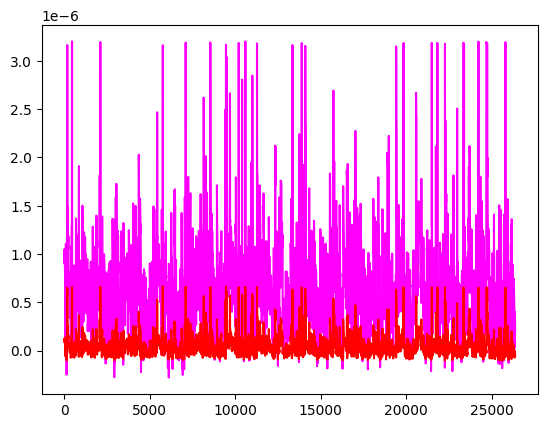

In [11]:
# look at baselines
for ch in chs:
    baselines = RQs[f'MeanBase_{ch}']
    plt.plot(baselines,color=MIDAScolors[MIDASchs.index(ch)])

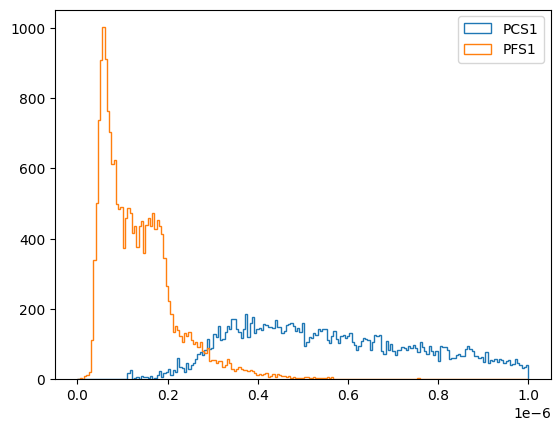

In [12]:
bins=np.linspace(0,1e-6,200)
for ch in chs:
    plt.hist(RQs[f'OF_A_{ch}'],bins=bins,histtype='step',label=ch)
    plt.legend()

In [13]:
# "spectrum" plot
bins = np.linspace(0,2e-6,200)
rq.hist1D('OF_A_PCS1',bins=bins)
rq.hist1D('OF_A_PFS1',bins=bins)

AttributeError: 'RQ' object has no attribute 'hist1D'

In [ ]:
# chi2 vs amplitude plot
ch = chs[1]
rq.hist2d(f'OF_A_{ch}',f'OF_chi2_{ch}')
# format

In [ ]:
# "partition" plot
rq.plot2d('OF_A_PCS1','OF_A_PFS1')
# format

Now let's attempt some cuts...

In [ ]:
# cut on Baseline and chi2

The resolution improved!

Now try weighting channels...

In [ ]:
# 

In [ ]:
# plot single-channel chi2 vs OFA

ch = 'PFS1'

xkey = f'OF_A_{ch}' # Amplitude (t-dep)
ykey = f'OF_chi2_{ch}' # chi2 (t-dep)
x = RQs[xkey]*1e6
y = RQs[ykey]

# cuts?
baseline = RQs[f'MeanBase_{ch}']*1e6
cuts = (baseline < 0.1) # cut mask

# bins
bins = (np.linspace(min(x),max(x),200),np.linspace(0,max(y),200))
plt.hist2d(x,y,bins=bins,cmap='binary',norm=LogNorm(),alpha=0.8)
plt.hist2d(x[cuts],y[cuts],bins=bins,norm=LogNorm())
# chi2 ~ number of data points in trace (8192)
plt.axhline(tracelen,color='k',alpha=0.3)
plt.text(bins[0][-1]*0.5,9000,r'$\chi^2_{red}=1$')
plt.colorbar()
plt.xlabel(xkey+r' ($\mu A$)')
plt.ylabel(ykey)


In [ ]:
# plot 1D amplitude histograms

# bins
#bins = np.linspace(0,max(x),200)
bins = np.arange(0,0.3,0.001)
for ch in chs:
    xkey = f'OF_A_{ch}' # Amplitude (t-dep)
    x = RQs[xkey]*1e6
    plt.hist(x,bins=bins,histtype='step',color=colors[allchs.index(ch)],label=ch)
plt.xlabel(xkey+r' ($\mu A$)')
plt.ylabel('number')
plt.yscale('log')
plt.legend()


In [ ]:
# plot OFA vs OFA2

ch = 'PCS1' #'PBS2'
ch2= 'PFS1'

xkey = f'OF_A_{ch}'
ykey = f'OF_A_{ch2}'
x = RQs[xkey]*1e6
y = RQs[ykey]*1e6

#bins
bins = (np.linspace(min(x),max(x),200),np.linspace(0,max(y),200))

plt.hist2d(x,y,bins=bins,norm=LogNorm())
plt.colorbar()
plt.xlabel(xkey+r' ($\mu A$)')
plt.ylabel(ykey+r' ($\mu A$)')